# MSDS 422 Assignment 4 - Neural Networks

Predicting the same dataset as the previous weeks

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf

from sklearn.model_selection import train_test_split # easier than writing it myself /shrug
from sklearn import metrics


# make a ping once everything has finished
from sys import platform
if 'win' in platform:
    import winsound


# also make my axis spacing nice
plt.rcParams.update({'figure.autolayout':True})


# for the sms gateway sending
import smtplib
import ssl
from os import getenv

In [6]:

# make a fun sound when we finish stuff -- since the MC models take a while to run

def doneTone():
    low_A = 440
    C_sharp = int(440* 2**(4/12))
    E = int(440* 2**(7/12))
    hi_A = int(440* 2)

    winsound.Beep(low_A, 500)
    winsound.Beep(E, 500)
    winsound.Beep(C_sharp, 500)
    winsound.Beep(hi_A, 1500)


def errorTone():
    hi_A = int(440* 2)
    A_flat = int(440 * 2**(11/12))
    G = int(440 * 2**(10/12))
    G_flat = int(440 * 2**(9/12))

    winsound.Beep(hi_A, 500)
    winsound.Beep(A_flat, 500)
    winsound.Beep(G, 500)
    winsound.Beep(G_flat, 500)


In [7]:
# To send a text when you've finished everything
class doneText():
    def __init__(self):
        self.notif_email = getenv('notif_email') # source for this email
        self.notif_pass = getenv('notif_pass')   # pass for the source email
        self.notif_target = getenv('notif_target') # target email [phone_num]@[mmsgateway]

    def send(self, message):
        ssl_context = ssl.create_default_context()
        with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=ssl_context) as server:
            server.login(self.notif_email, self.notif_pass)
            result = server.sendmail(self.notif_email, self.notif_target, f"Subject:\n{message}")

            print(f"Text send result: {result}")
            server.quit()


In [8]:
dnTxt = doneText()

Now to define a method of showing the ROC curve

In [10]:
def ROC_AUC_show(data_train_target, data_train_pred, data_valid_target, data_valid_pred, plot=True):
    fpr_train, tpr_train, _ = metrics.roc_curve(data_train_target, data_train_pred)
    auc_train = metrics.auc(fpr_train, tpr_train)
    fpr_test, tpr_test, _ = metrics.roc_curve(data_valid_target, data_valid_pred)
    auc_test = metrics.auc(fpr_test, tpr_test)

    if plot:
        fig,ax = plt.subplots()
        ax.plot(fpr_train,tpr_train, label=f"AUC Train: {auc_train:0.2f}")
        ax.plot(fpr_test,tpr_test, label=f"AUC test: {auc_test:0.2f}")
        ax.legend()
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')

    return fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test

make sure tensorflow sees the GPU

In [11]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Bring in the datasets
Split them into two sets *bad_flag* and *loss_amt* previous weeks. We'll just bring it in to make life easier

In [12]:
flag_df = pd.read_excel("C:\\Users\\17204\\Documents\\git\\MSDS_coursework\\422\\Assignment_3\\HMEQ_Loss_export_flag.xlsx")
loss_df = pd.read_excel("C:\\Users\\17204\\Documents\\git\\MSDS_coursework\\422\\Assignment_3\\HMEQ_Loss_export_loss.xlsx")

flag_df.drop(columns="Unnamed: 0", inplace=True)
loss_df.drop(columns="Unnamed: 0", inplace=True)

And split everything into testing and training datasets.

In [13]:
flag_df_train, flag_df_valid = train_test_split(flag_df, train_size=.8)
loss_df_train, loss_df_valid = train_test_split(loss_df, train_size=.8)

# then split the targets for each
flag_df_train_target = flag_df_train.pop('TARGET_BAD_FLAG')
flag_df_valid_target = flag_df_valid.pop('TARGET_BAD_FLAG')
loss_df_train_target = loss_df_train.pop('TARGET_LOSS_AMT')
loss_df_valid_target = loss_df_valid.pop('TARGET_LOSS_AMT')

We did some variable selection stuff in previous weeks, so let's only use that to make the training a little faster. I'll just use the variables from making a random forest

Curious to see how things compare.

<br>
<br>

_'Bad Flag' Random Forest important variables_

['impute_VALUE', 'impute_DEROG', 'impute_DELINQ', 'impute_CLAGE', 'impute_CLNO', 'impute_DEBTINC', 'impute_LOAN']

<br>

_Loss Prediction important variables_

['impute_CLNO', 'impute_DEBTINC', 'impute_LOAN']

<br>
<br>

In [14]:
flag_rf_vars = ['impute_VALUE', 'impute_DEROG', 'impute_DELINQ', 'impute_CLAGE', 'impute_CLNO', 'impute_DEBTINC', 'impute_LOAN']
loss_rf_vars = ['impute_CLNO', 'impute_DEBTINC', 'impute_LOAN']



### Bring on the models!
Let's start by just building a model a piece.

Let's just start with linear regression by way of a single layer NN for the flag. 

In [8]:
import time

In [9]:
active_func = tf.keras.activations.linear
loss_metric = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
n_epochs = 3000

# in_dim = loss_df_train[loss_rf_vars].shape[1]
in_dim = loss_df_train.shape[1]

# so the idea is that the weights of the lin. reg. array are replaced with
# the weights of the NN (should work out to be the same values) and activation
# is just a sum. So, it's exactly the same, just trained differently
layer_00 = tf.keras.layers.Dense(units = 1, activation=active_func, input_dim = in_dim) #imported above

mdl = tf.keras.models.Sequential()
mdl.add(layer_00)
mdl.compile(loss = loss_metric, optimizer = optimizer)
with tf.device("/GPU:0"):
    # mdl.fit(np.array(loss_df_train[loss_rf_vars]), np.array(loss_df_train_target), epochs=n_epochs, verbose=False)
    mdl.fit(np.array(loss_df_train), np.array(loss_df_train_target), epochs=n_epochs, verbose=False)
# mdl.fit(loss_df_train, loss_df_train_target, epochs=n_epochs)
# mdl.evaluate(loss_df_valid[loss_rf_vars], loss_df_valid_target)
mdl.evaluate(loss_df_valid, loss_df_valid_target)

8/8 [==============================] - 0s 1ms/step - loss: 29602060.0000


29602060.0

Test the model, look at the predictive accuracy

In [10]:
loss_df_train_pred = mdl.predict(loss_df_train)
loss_df_valid_pred = mdl.predict(loss_df_valid)
# loss_df_train_pred = mdl.predict(loss_df_train[loss_rf_vars])
# loss_df_valid_pred = mdl.predict(loss_df_valid[loss_rf_vars])
print(f"Training mse: {metrics.mean_squared_error(loss_df_train_target,loss_df_train_pred)}")
print(f"Testing mse: {metrics.mean_squared_error(loss_df_valid_target,loss_df_valid_pred)}")
print(f"Training r2: {metrics.r2_score(loss_df_train_target,loss_df_train_pred)}")
print(f"Testing r2: {metrics.r2_score(loss_df_valid_target,loss_df_valid_pred)}")

8/8 [==============================] - 0s 858us/step
Training mse: 28025429.69101042
Testing mse: 29602060.814007267
Training r2: 0.7719948869046451
Testing r2: 0.6866921276541975


In [11]:
from sklearn import linear_model

mdl = linear_model.LinearRegression()
mdl.fit(loss_df_train, loss_df_train_target)
# mdl.fit(loss_df_train[flag_rf_vars], loss_df_train_target)

loss_df_train_pred = mdl.predict(loss_df_train)
# loss_df_train_pred = mdl.predict(loss_df_train[flag_rf_vars])
loss_df_valid_pred = mdl.predict(loss_df_valid)
# loss_df_valid_pred = mdl.predict(loss_df_valid[flag_rf_vars])
print(f"Training r2: {metrics.r2_score(loss_df_train_target,loss_df_train_pred)}")
print(f"Testing r2: {metrics.r2_score(loss_df_valid_target,loss_df_valid_pred)}")

Training r2: 0.8410207880836711
Testing r2: 0.7520049406160529


Now for basic logistic regression for the "Flag" data

In [12]:
mdl = linear_model.LogisticRegression(max_iter=1000)
mdl.fit(flag_df_train, flag_df_train_target)

flag_df_train_pred = mdl.predict(flag_df_train)
flag_df_valid_pred = mdl.predict(flag_df_valid)
print(f"Training Accuracy Score: {metrics.accuracy_score(flag_df_train_target, flag_df_train_pred)}")
print(f"Training MAE: {metrics.mean_absolute_error(flag_df_train_target, flag_df_train_pred)}")

Training Accuracy Score: 0.799496644295302
Training MAE: 0.200503355704698


Epoch 1/5000
149/149 [==============================] - 0s 1ms/step - loss: 945.1785
Epoch 2/5000
149/149 [==============================] - 0s 1ms/step - loss: 700.7765
Epoch 3/5000
149/149 [==============================] - 0s 1ms/step - loss: 491.1511
Epoch 4/5000
149/149 [==============================] - 0s 1ms/step - loss: 272.3611
Epoch 5/5000
149/149 [==============================] - 0s 1ms/step - loss: 75.6419
Epoch 6/5000
149/149 [==============================] - 0s 1ms/step - loss: 10.2705
Epoch 7/5000
149/149 [==============================] - 0s 1ms/step - loss: 6.9875
Epoch 8/5000
149/149 [==============================] - 0s 1ms/step - loss: 10.3454
Epoch 9/5000
149/149 [==============================] - 0s 1ms/step - loss: 6.5385
Epoch 10/5000
149/149 [==============================] - 0s 1ms/step - loss: 5.3239
Epoch 11/5000
149/149 [==============================] - 0s 1ms/step - loss: 5.7614
Epoch 12/5000
149/149 [==============================] - 0s 1ms/step - los

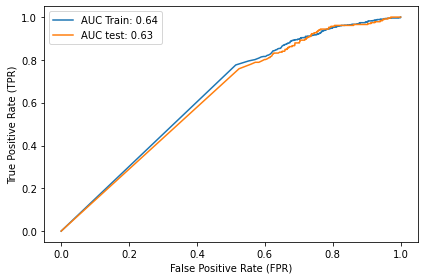

In [13]:
active_func = tf.keras.activations.sigmoid # sigmoid since we want a yes/no
loss_metric = tf.keras.losses.BinaryCrossentropy() # should we do this or Binary Crossentopy? 
optimizer = tf.keras.optimizers.Adam()

n_epochs = 5000 # this seem a little high, but I've been getting shitty results otherwise
in_dim = flag_df_train.shape[1]
# in_dim = flag_df_train[flag_rf_vars].shape[1]

layer_00 = tf.keras.layers.Dense(input_dim=in_dim, activation=active_func, units=1)


# nesting everything inside of a try/except so that we can run the following cells if there's an error

try:

    mdl = tf.keras.Sequential()
    mdl.add(layer_00)
    mdl.compile(loss=loss_metric, optimizer=optimizer)
    with tf.device("/GPU:0"):
        mdl.fit(flag_df_train, flag_df_train_target, epochs=n_epochs)
        # mdl.fit(flag_df_train[flag_rf_vars], flag_df_train_target, epochs=n_epochs)

    mdl.evaluate(flag_df_valid, flag_df_valid_target)
    # mdl.evaluate(flag_df_valid[flag_rf_vars], flag_df_valid_target)

    flag_df_train_pred = mdl.predict(flag_df_train) # full dataset
    flag_df_valid_pred = mdl.predict(flag_df_valid) # full dataset
    # flag_df_train_pred = mdl.predict(flag_df_train[flag_rf_vars]) # subset of fields
    # flag_df_valid_pred = mdl.predict(flag_df_valid[flag_rf_vars]) # subset of fields
    print(f"Training accuracy: {1 - metrics.mean_absolute_error(flag_df_train_target, flag_df_train_pred)}") # we'll look at absolute error for the moment -- 0s and 1s
    print(f"Testing accuracy: {1 - metrics.mean_absolute_error(flag_df_valid_target, flag_df_valid_pred)}")  # math works out the same to RMSE :)
    print(f"Training R2: {metrics.r2_score(flag_df_train_target, flag_df_train_pred)}")
    print(f"Testing R2: {metrics.r2_score(flag_df_valid_target, flag_df_valid_pred)}")


    ROC_AUC_show(flag_df_train_target, flag_df_train_pred, flag_df_valid_target, flag_df_valid_pred)

except Exception as error:
    print(error)
    errorTone()

### Same activations, just making layers with more neurons.


There were a few suggestions for the number of neurons to start with on an individual layer, but we'll just go for slightly more than the number of inputs


Starting with the "Loss" predictions -- meaning the linear activations

In [14]:
active_func = tf.keras.activations.linear
loss_metric = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
n_epochs = 5000

# in_dim = loss_df_train[loss_rf_vars].shape[1]
in_dim = loss_df_train.shape[1]

# Multiple layers with linear activation functions are mathematically equivalent
# to a single layer, so this is just proving a point
layer_00 = tf.keras.layers.Dense(units = 20, activation=active_func, input_dim = in_dim) #
layer_01 = tf.keras.layers.Dense(units = 1, activation=active_func, input_dim = 20)

mdl = tf.keras.models.Sequential()
mdl.add(layer_00)
mdl.add(layer_01)
mdl.compile(loss = loss_metric, optimizer = optimizer)
with tf.device("/GPU:0"): # found this necessary to force it to use the GPU
    # mdl.fit(np.array(loss_df_train[loss_rf_vars]), np.array(loss_df_train_target), epochs=n_epochs, verbose=False)
    mdl.fit(np.array(loss_df_train), np.array(loss_df_train_target), epochs=n_epochs, verbose=False)
# mdl.evaluate(loss_df_valid[loss_rf_vars], loss_df_valid_target)
mdl.evaluate(loss_df_valid, loss_df_valid_target)


# loss_df_train_pred = mdl.predict(loss_df_train[loss_rf_vars])
# loss_df_valid_pred = mdl.predict(loss_df_valid[loss_rf_vars])
loss_df_train_pred = mdl.predict(loss_df_train)
loss_df_valid_pred = mdl.predict(loss_df_valid)
print(f"Training mse: {metrics.mean_absolute_error(loss_df_train_target,loss_df_train_pred)}")
print(f"Testing mse: {metrics.mean_absolute_error(loss_df_valid_target,loss_df_valid_pred)}")
print(f"Training r2: {metrics.r2_score(loss_df_train_target,loss_df_train_pred)}")
print(f"Testing r2: {metrics.r2_score(loss_df_valid_target,loss_df_valid_pred)}")

# doneTone()


8/8 [==============================] - 0s 0s/step
Training mse: 22354259.720216174
Testing mse: 25885665.148197327
Training r2: 0.8181335461448526
Testing r2: 0.7260264167824433


Same for the logistic activations for the "Bad Flag" predictions. 

Epoch 1/5000
149/149 [==============================] - 0s 1ms/step - loss: 3965.4333
Epoch 2/5000
149/149 [==============================] - 0s 1ms/step - loss: 200.1802
Epoch 3/5000
149/149 [==============================] - 0s 1ms/step - loss: 82.4346
Epoch 4/5000
149/149 [==============================] - 0s 1ms/step - loss: 75.3806
Epoch 5/5000
149/149 [==============================] - 0s 1ms/step - loss: 60.4016
Epoch 6/5000
149/149 [==============================] - 0s 1ms/step - loss: 68.3866
Epoch 7/5000
149/149 [==============================] - 0s 1ms/step - loss: 84.3790
Epoch 8/5000
149/149 [==============================] - 0s 1ms/step - loss: 58.0353
Epoch 9/5000
149/149 [==============================] - 0s 1ms/step - loss: 57.9389
Epoch 10/5000
149/149 [==============================] - 0s 1ms/step - loss: 62.9836
Epoch 11/5000
149/149 [==============================] - 0s 1ms/step - loss: 80.0246
Epoch 12/5000
149/149 [==============================] - 0s 1ms/step - 

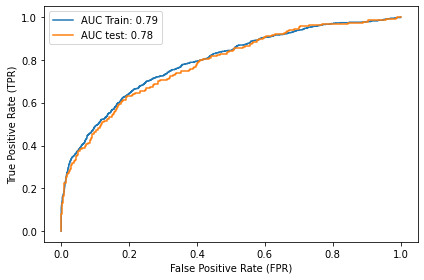

In [15]:
active_func = tf.keras.activations.sigmoid # sigmoid since we want a yes/no
loss_metric = tf.keras.losses.BinaryCrossentropy() # true/false. Should work better than MSE
optimizer = tf.keras.optimizers.Adam()

n_epochs = 5000 # this seem a little high, but I've been getting shitty results otherwise
in_dim = flag_df_train.shape[1]
# in_dim = flag_df_train[flag_rf_vars].shape[1]

try:

    layer_00 = tf.keras.layers.Dense(input_dim=in_dim, activation=tf.keras.activations.linear, units=20)
    layer_out = tf.keras.layers.Dense(input_dim=20, activation=tf.keras.activations.sigmoid, units=1) # convert from linear into a TF


    mdl = tf.keras.Sequential()
    mdl.add(layer_00)
    mdl.add(layer_out)
    mdl.compile(loss=loss_metric, optimizer=optimizer)
    with tf.device("/GPU:0"):
        mdl.fit(flag_df_train, flag_df_train_target, epochs=n_epochs)
        # mdl.fit(flag_df_train[flag_rf_vars], flag_df_train_target, epochs=n_epochs)

    mdl.evaluate(flag_df_valid, flag_df_valid_target)
    # mdl.evaluate(flag_df_valid[flag_rf_vars], flag_df_valid_target)

    flag_df_train_pred = mdl.predict(flag_df_train) # full dataset
    flag_df_valid_pred = mdl.predict(flag_df_valid) # full dataset
    # flag_df_train_pred = mdl.predict(flag_df_train[flag_rf_vars]) # subset of fields
    # flag_df_valid_pred = mdl.predict(flag_df_valid[flag_rf_vars]) # subset of fields
    print(f"Training accuracy: {1 - metrics.mean_absolute_error(flag_df_train_target, flag_df_train_pred)}")
    print(f"Testing accuracy: {1 - metrics.mean_absolute_error(flag_df_valid_target, flag_df_valid_pred)}")

    ROC_AUC_show(flag_df_train_target, flag_df_train_pred, flag_df_valid_target, flag_df_valid_pred)


except Exception as error:
    print(error)
    errorTone()

### Swapping up the activation functions

Let's try with ReLU for both of them, since that's a pretty popular activation method

I suspect that it will predict the loss amounts pretty well, but I suspect it will have difficulties with the "Bad Flag" since that output is just 0 and 1. With that in mind, we'll try Bad Flag with just ReLU, and with ReLU into a sigmoid read out layer.


Starting with loss again

In [16]:
active_func = tf.keras.activations.relu
loss_metric = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
n_epochs = 5000

# in_dim = loss_df_train[loss_rf_vars].shape[1]
in_dim = loss_df_train.shape[1]

# so the idea is that the weights of the lin. reg. array are replaced with
# the weights of the NN (should work out to be the same values) and activation
# is just a sum. So, it's exactly the same, just trained differently
layer_00 = tf.keras.layers.Dense(units = 20, activation=active_func, input_dim = in_dim) 
layer_out = tf.keras.layers.Dense(units = 1, activation=active_func, input_dim = 20) # could alternatively just do linear for the readout layer. May try later

mdl = tf.keras.models.Sequential()
mdl.add(layer_00)
mdl.add(layer_out)
mdl.compile(loss = loss_metric, optimizer = optimizer)
with tf.device("/GPU:0"): # found this necessary to force it to use the GPU
    # mdl.fit(np.array(loss_df_train[loss_rf_vars]), np.array(loss_df_train_target), epochs=n_epochs, verbose=False)
    mdl.fit(np.array(loss_df_train), np.array(loss_df_train_target), epochs=n_epochs, verbose=False)
mdl.evaluate(loss_df_valid, loss_df_valid_target)


# loss_df_train_pred = mdl.predict(loss_df_train[loss_rf_vars])
# loss_df_valid_pred = mdl.predict(loss_df_valid[loss_rf_vars])
loss_df_train_pred = mdl.predict(loss_df_train)
loss_df_valid_pred = mdl.predict(loss_df_valid)
print(f"Training mse: {metrics.mean_squared_error(loss_df_train_target,loss_df_train_pred)}")
print(f"Testing mse: {metrics.mean_squared_error(loss_df_valid_target,loss_df_valid_pred)}")
print(f"Training r2: {metrics.r2_score(loss_df_train_target,loss_df_train_pred)}")
print(f"Testing r2: {metrics.r2_score(loss_df_valid_target,loss_df_valid_pred)}")

8/8 [==============================] - 0s 672us/step
Training mse: 15652905.619871061
Testing mse: 19494084.970643293
Training r2: 0.8726534238554633
Testing r2: 0.7936748281190449


"Bad Flag" predictions with just ReLU

Epoch 1/5000
149/149 [==============================] - 0s 1ms/step - loss: 12.1885
Epoch 2/5000
149/149 [==============================] - 0s 1ms/step - loss: 12.1885
Epoch 3/5000
149/149 [==============================] - 0s 1ms/step - loss: 12.1885
Epoch 4/5000
149/149 [==============================] - 0s 1ms/step - loss: 12.1885
Epoch 5/5000
149/149 [==============================] - 0s 1ms/step - loss: 12.1885
Epoch 6/5000
149/149 [==============================] - 0s 1ms/step - loss: 12.1885
Epoch 7/5000
149/149 [==============================] - 0s 1ms/step - loss: 12.1885
Epoch 8/5000
149/149 [==============================] - 0s 1ms/step - loss: 12.1885
Epoch 9/5000
149/149 [==============================] - 0s 1ms/step - loss: 12.1885
Epoch 10/5000
149/149 [==============================] - 0s 1ms/step - loss: 12.1885
Epoch 11/5000
149/149 [==============================] - 0s 1ms/step - loss: 12.1885
Epoch 12/5000
149/149 [==============================] - 0s 1ms/step - los

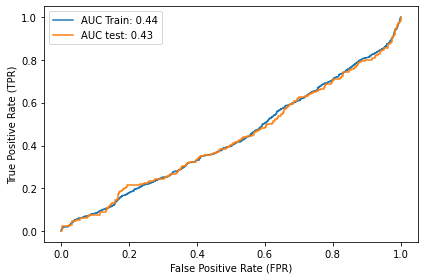

In [17]:
active_func = tf.keras.activations.relu # sigmoid since we want a yes/no
loss_metric = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

n_epochs = 5000 # this seem a little high, but I've been getting shitty results otherwise
in_dim = flag_df_train.shape[1]
# in_dim = flag_df_train[flag_rf_vars].shape[1]

try:
    layer_00 = tf.keras.layers.Dense(input_dim=in_dim, activation=active_func, units=20)
    layer_out = tf.keras.layers.Dense(input_dim=in_dim, activation=active_func, units=1)


    mdl = tf.keras.Sequential()
    mdl.add(layer_00)
    mdl.add(layer_out)
    mdl.compile(loss=loss_metric, optimizer=optimizer)
    with tf.device("/GPU:0"):
        mdl.fit(flag_df_train, flag_df_train_target, epochs=n_epochs)
        # mdl.fit(flag_df_train[flag_rf_vars], flag_df_train_target, epochs=n_epochs)

    mdl.evaluate(flag_df_valid, flag_df_valid_target)
    # mdl.evaluate(flag_df_valid[flag_rf_vars], flag_df_valid_target)

    flag_df_train_pred = mdl.predict(flag_df_train) # full dataset
    flag_df_valid_pred = mdl.predict(flag_df_valid) # full dataset
    # flag_df_train_pred = mdl.predict(flag_df_train[flag_rf_vars]) # subset of fields
    # flag_df_valid_pred = mdl.predict(flag_df_valid[flag_rf_vars]) # subset of fields
    print(f"Training accuracy: {1 - metrics.mean_absolute_error(flag_df_train_target, flag_df_train_pred)}")
    print(f"Testing accuracy: {1 - metrics.mean_absolute_error(flag_df_valid_target, flag_df_valid_pred)}")

    ROC_AUC_show(flag_df_train_target, flag_df_train_pred, flag_df_valid_target, flag_df_valid_pred)

except Exception as error:
    print(error)
    errorTone()

Epoch 1/5000
149/149 [==============================] - 0s 1ms/step - loss: 1415.5249
Epoch 2/5000
149/149 [==============================] - 0s 1ms/step - loss: 122.4252
Epoch 3/5000
149/149 [==============================] - 0s 1ms/step - loss: 94.8611
Epoch 4/5000
149/149 [==============================] - 0s 1ms/step - loss: 75.0769
Epoch 5/5000
149/149 [==============================] - 0s 1ms/step - loss: 77.6570
Epoch 6/5000
149/149 [==============================] - 0s 1ms/step - loss: 55.5388
Epoch 7/5000
149/149 [==============================] - 0s 1ms/step - loss: 54.8830
Epoch 8/5000
149/149 [==============================] - 0s 1ms/step - loss: 42.2132
Epoch 9/5000
149/149 [==============================] - 0s 1ms/step - loss: 66.0284
Epoch 10/5000
149/149 [==============================] - 0s 1ms/step - loss: 58.7302
Epoch 11/5000
149/149 [==============================] - 0s 1ms/step - loss: 55.3420
Epoch 12/5000
149/149 [==============================] - 0s 1ms/step - 

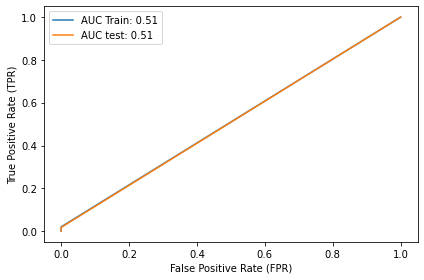

In [18]:

active_func = tf.keras.activations.relu # 
loss_metric = tf.keras.losses.BinaryCrossentropy()
# loss_metric = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

n_epochs = 5000 # this seem a little high, but I've been getting shitty results otherwise
in_dim = flag_df_train.shape[1]
# in_dim = flag_df_train[flag_rf_vars].shape[1]

try:
    layer_00 = tf.keras.layers.Dense(input_dim=in_dim, activation=active_func, units=20)
    layer_01 = tf.keras.layers.Dense(input_dim=20, activation=tf.keras.activations.sigmoid, units=1)


    mdl = tf.keras.Sequential()
    mdl.add(layer_00)
    mdl.add(layer_01)
    mdl.compile(loss=loss_metric, optimizer=optimizer)
    with tf.device("/GPU:0"):
        mdl.fit(flag_df_train, flag_df_train_target, epochs=n_epochs)
        # mdl.fit(flag_df_train[flag_rf_vars], flag_df_train_target, epochs=n_epochs)

    mdl.evaluate(flag_df_valid, flag_df_valid_target)
    # mdl.evaluate(flag_df_valid[flag_rf_vars], flag_df_valid_target)


    flag_df_train_pred = mdl.predict(flag_df_train) # full dataset
    flag_df_valid_pred = mdl.predict(flag_df_valid) # full dataset
    # flag_df_train_pred = mdl.predict(flag_df_train[flag_rf_vars]) # subset of fields
    # flag_df_valid_pred = mdl.predict(flag_df_valid[flag_rf_vars]) # subset of fields
    print(f"Training accuracy: {1 - metrics.mean_absolute_error(flag_df_train_target, flag_df_train_pred)}")
    print(f"Testing accuracy: {1 - metrics.mean_absolute_error(flag_df_valid_target, flag_df_valid_pred)}")


    ROC_AUC_show(flag_df_train_target, flag_df_train_pred, flag_df_valid_target, flag_df_valid_pred)

except Exception as error:
    print(error)

### Multi hidden layer networks

Let's try with two hidden layers, using ReLU for the activations throughout

In [15]:
active_func = tf.keras.activations.relu
loss_metric = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

n_epochs = 10000 # going to need more time to train
in_dim = loss_df_train.shape[1]

layer_00 = tf.keras.layers.Dense(input_dim = in_dim, activation = active_func, units = 20)
layer_dropout_00 = tf.keras.layers.Dropout(.2)
layer_01 = tf.keras.layers.Dense(input_dim = 20, activation = active_func, units = 30)
layer_dropout_01 = tf.keras.layers.Dropout(.2)
layer_02 = tf.keras.layers.Dense(input_dim = 30, activation = active_func, units = 30)
layer_out = tf.keras.layers.Dense(input_dim = 30, activation = active_func, units = 1)

mdl = tf.keras.Sequential()
mdl.add(layer_00)
mdl.add(layer_dropout_00)
mdl.add(layer_01)
mdl.add(layer_dropout_01)
mdl.add(layer_02)
mdl.add(layer_out)
mdl.compile(loss=loss_metric, optimizer=optimizer)

try:
    with tf.device("/GPU:0"):
        mdl.fit(loss_df_train, loss_df_train_target, epochs=n_epochs)

    mdl.evaluate(loss_df_valid, loss_df_valid_target)
    loss_df_valid_pred = mdl.predict(loss_df_valid)
    dnTxt.send(f"Two hidden layer with relu for the loss estimates complete. Testing RMSE {metrics.mean_absolute_error(loss_df_valid_target, loss_df_valid_pred)}. Testing VAF {metrics.r2_score(loss_df_valid_target, loss_df_valid_pred)}")

except Exception as error:
    print(error)
    dnTxt.send(f"FAILED: two hidden layer with relu for loss estimates. \n{error}")
    errorTone




Epoch 1/10000
30/30 [==============================] - 2s 3ms/step - loss: 297208128.0000
Epoch 2/10000
30/30 [==============================] - 0s 3ms/step - loss: 297208192.0000
Epoch 3/10000
30/30 [==============================] - 0s 3ms/step - loss: 297208192.0000
Epoch 4/10000
30/30 [==============================] - 0s 3ms/step - loss: 297208160.0000
Epoch 5/10000
30/30 [==============================] - 0s 3ms/step - loss: 297208192.0000
Epoch 6/10000
30/30 [==============================] - 0s 3ms/step - loss: 297202656.0000
Epoch 7/10000
30/30 [==============================] - 0s 3ms/step - loss: 296239872.0000
Epoch 8/10000
30/30 [==============================] - 0s 3ms/step - loss: 199056240.0000
Epoch 9/10000
30/30 [==============================] - 0s 3ms/step - loss: 113835064.0000
Epoch 10/10000
30/30 [==============================] - 0s 3ms/step - loss: 91669280.0000
Epoch 11/10000
30/30 [==============================] - 0s 3ms/step - loss: 97527320.0000
Epoch 12/1

Epoch 1/5000
149/149 [==============================] - 1s 2ms/step - loss: 711.2365
Epoch 2/5000
149/149 [==============================] - 0s 2ms/step - loss: 226.4486
Epoch 3/5000
149/149 [==============================] - 0s 2ms/step - loss: 128.6010
Epoch 4/5000
149/149 [==============================] - 0s 2ms/step - loss: 82.6659
Epoch 5/5000
149/149 [==============================] - 0s 2ms/step - loss: 62.3667
Epoch 6/5000
149/149 [==============================] - 0s 2ms/step - loss: 46.1100
Epoch 7/5000
149/149 [==============================] - 0s 2ms/step - loss: 34.6109
Epoch 8/5000
149/149 [==============================] - 0s 2ms/step - loss: 27.8727
Epoch 9/5000
149/149 [==============================] - 0s 2ms/step - loss: 20.1603
Epoch 10/5000
149/149 [==============================] - 0s 2ms/step - loss: 16.8013
Epoch 11/5000
149/149 [==============================] - 0s 2ms/step - loss: 13.3183
Epoch 12/5000
149/149 [==============================] - 0s 2ms/step - 

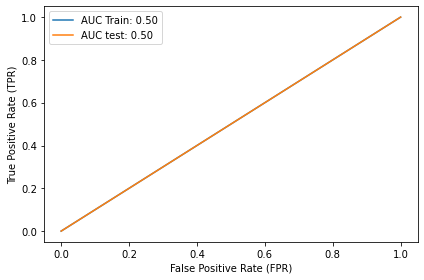

In [20]:
active_func = tf.keras.activations.relu
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.BinaryCrossentropy() 

n_epochs = 10000
in_dim = flag_df_train.shape[1]

layer_00 = tf.keras.layers.Dense(input_dim = in_dim, activation = active_func, units = 20)
layer_dropout_00 = tf.keras.layers.Dropout(.2)
layer_01 = tf.keras.layers.Dense(input_dim = 20, activation = active_func, units = 30)
layer_dropout_01 = tf.keras.layers.Dropout(.2)
layer_02 = tf.keras.layers.Dense(input_dim = 30, activation = active_func, units = 30)
layer_out = tf.keras.layers.Dense(input_dim = 30, activation = tf.keras.activations.sigmoid, units = 1)

try:
    mdl = tf.keras.Sequential()
    mdl.add(layer_00)
    mdl.add(layer_dropout_00)
    mdl.add(layer_01)
    mdl.add(layer_dropout_01)
    mdl.add(layer_02)
    mdl.add(layer_out)
    mdl.compile(loss=loss_func, optimizer=optimizer)

    with tf.device("/GPU:0"):
        mdl.fit(flag_df_train, flag_df_train_target, epochs=n_epochs)

    mdl.evaluate(flag_df_valid, flag_df_valid_target)

    flag_df_train_pred = mdl.predict(flag_df_train)
    flag_df_valid_pred = mdl.predict(flag_df_valid)
    train_acc = 1 - metrics.mean_absolute_error(flag_df_train_target, flag_df_train_pred)
    test_acc = 1 - metrics.mean_absolute_error(flag_df_valid_target, flag_df_valid_pred)
    print(f"Training accuracy: {train_acc}")
    print(f"Testing accuracy: {test_acc}")
    dnTxt.send(f"COMPLETED\nTwo hidden layer NN, ReLU with sigmoid output for Bad Flag.\nTesting Accuracy: {test_acc}")

    ROC_AUC_show(flag_df_train_target, flag_df_train_pred, flag_df_valid_target, flag_df_valid_pred)

except Exception as error:
    print(error)
    dnTxt.send(f"FAILED: Two hidden layer NN, ReLU with sigmoid output for Bad Flag.\n{error}")
    errorTone()

### Changing the activation functions again
Let's try with softplus as the intermediate layers, instead of ReLU

In [21]:

active_func = tf.keras.activations.softplus
loss_metric = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

n_epochs = 5000 # going to need more time to train
in_dim = loss_df_train.shape[1]

layer_00 = tf.keras.layers.Dense(input_dim = in_dim, activation = active_func, units = 20)
layer_dropout_00 = tf.keras.layers.Dropout(.2)
layer_01 = tf.keras.layers.Dense(input_dim = 20, activation = active_func, units = 30)
layer_dropout_01 = tf.keras.layers.Dropout(.2)
layer_02 = tf.keras.layers.Dense(input_dim = 30, activation = active_func, units = 30)
layer_out = tf.keras.layers.Dense(input_dim = 30, activation = active_func, units = 1)

mdl = tf.keras.Sequential()
mdl.add(layer_00)
mdl.add(layer_dropout_00)
mdl.add(layer_01)
mdl.add(layer_dropout_01)
mdl.add(layer_02)
mdl.add(layer_out)
mdl.compile(loss=loss_metric, optimizer=optimizer)

try:
    with tf.device("/GPU:0"):
        mdl.fit(loss_df_train, loss_df_train_target, epochs=n_epochs)

    mdl.evaluate(loss_df_valid, loss_df_valid_target)

except Exception as error:
    print(error)
    errorTone




8/8 [==============================] - 0s 1ms/step - loss: 83286776.0000


Epoch 1/5000
149/149 [==============================] - 0s 2ms/step - loss: 802.0482
Epoch 2/5000
149/149 [==============================] - 0s 2ms/step - loss: 233.6146
Epoch 3/5000
149/149 [==============================] - 0s 2ms/step - loss: 136.2738
Epoch 4/5000
149/149 [==============================] - 0s 2ms/step - loss: 106.8208
Epoch 5/5000
149/149 [==============================] - 0s 2ms/step - loss: 70.9079
Epoch 6/5000
149/149 [==============================] - 0s 2ms/step - loss: 51.8404
Epoch 7/5000
149/149 [==============================] - 0s 2ms/step - loss: 37.0344
Epoch 8/5000
149/149 [==============================] - 0s 2ms/step - loss: 32.8747
Epoch 9/5000
149/149 [==============================] - 0s 2ms/step - loss: 27.7919
Epoch 10/5000
149/149 [==============================] - 0s 2ms/step - loss: 22.7770
Epoch 11/5000
149/149 [==============================] - 0s 2ms/step - loss: 18.8471
Epoch 12/5000
149/149 [==============================] - 0s 2ms/step -

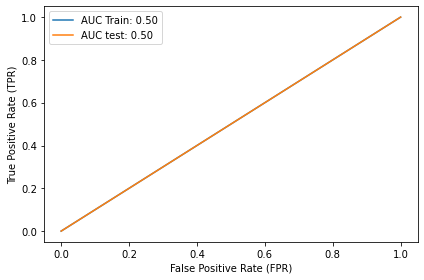

In [22]:

active_func = tf.keras.activations.softplus
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.BinaryCrossentropy() 

n_epochs = 5000
in_dim = flag_df_train.shape[1]

layer_00 = tf.keras.layers.Dense(input_dim = in_dim, activation = active_func, units = 20)
layer_dropout_00 = tf.keras.layers.Dropout(.2)
layer_01 = tf.keras.layers.Dense(input_dim = 20, activation = active_func, units = 30)
layer_dropout_01 = tf.keras.layers.Dropout(.2)
layer_02 = tf.keras.layers.Dense(input_dim = 30, activation = active_func, units = 30)
layer_out = tf.keras.layers.Dense(input_dim = 30, activation = tf.keras.activations.sigmoid, units = 1)

try:
    mdl = tf.keras.Sequential()
    mdl.add(layer_00)
    mdl.add(layer_dropout_00)
    mdl.add(layer_01)
    mdl.add(layer_dropout_01)
    mdl.add(layer_02)
    mdl.add(layer_out)
    mdl.compile(loss=loss_func, optimizer=optimizer)

    with tf.device("/GPU:0"):
        mdl.fit(flag_df_train, flag_df_train_target, epochs=n_epochs)

    mdl.evaluate(flag_df_valid, flag_df_valid_target)

    flag_df_train_pred = mdl.predict(flag_df_train)
    flag_df_valid_pred = mdl.predict(flag_df_valid)
    print(f"Training accuracy: {1 - metrics.mean_absolute_error(flag_df_train_target, flag_df_train_pred)}")
    print(f"Testing accuracy: {1 - metrics.mean_absolute_error(flag_df_valid_target, flag_df_valid_pred)}")

    ROC_AUC_show(flag_df_train_target, flag_df_train_pred, flag_df_valid_target, flag_df_valid_pred)

except Exception as error:
    print(error)
    errorTone()

### Everything's done!
Let someone know

Right now it's just set up to play a tone

In [23]:
doneTone()

NameError: name 'doneTone' is not defined